a new experiment with fixed initial copy number

In [1]:
import numpy as np
import sys
sys.path.insert(1,'./src/')
from models import ChemicalReactionNetwork
from matplotlib import pyplot as plt
from tqdm import tqdm
import corner
from copy import deepcopy

See [description of this notebook](./questions.md/#july-17th-non-abc)

In [2]:
species = 'A B C'.split()
reactions = [
    ({'A': 1}, {'B': 1}),
    ({'B': 1}, {'A': 1}),
    ({'B': 1}, {'C': 1}),
    ({'C': 1}, {'B': 1}),
]

switch_reaction = {
    0: 3,
    1: 2,
    2: 1,
    3: 0
}

kinetic_rates = np.array([4e-2,3e-1,1e-1,2e-2])
# some of the kinetic rates has to equal. 

model = ChemicalReactionNetwork(reactions, species, kinetic_rates)

X_init = np.array([10,20,30])

T = 30

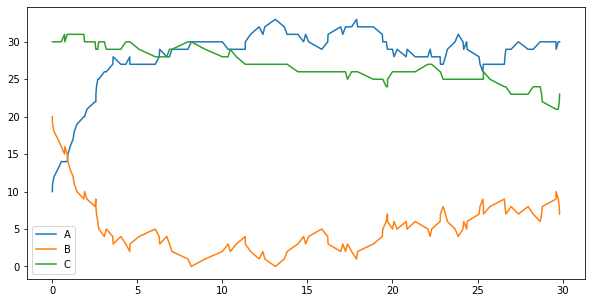

In [3]:
x,r,t = model.gilespie(X_init,T)
plt.figure(figsize=(10,5))
for i in range(3):
    plt.plot(t,x[:,i],label=species[i])
plt.legend();

the observables are only copy number of `B`, so our observation should be that:


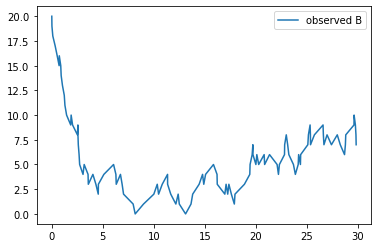

In [4]:
b = model.get_observation(t,x,'B').flatten()
plt.plot(t,b,label='observed B')
plt.legend();

Now, let's think what's in a state:

- reaction time $t_i$
- populations of the 3 species $a_i,b_i,c_i$

So the first step is to generate an initial state based on our observation. 

The observation provides for us the $t_i,a_i$. I will use a random number generator to generate an initial guess of $b_i, c_i$


In [5]:
def get_r(X):
    
    a = X[:,0]
    c = X[:,2]
    r = np.zeros(len(a)-1,dtype=int)
    
    diff_a = np.diff(a,1)
    diff_c = np.diff(c,1)
    r[diff_a==-1] = 0
    r[diff_a==1] = 1
    r[diff_c==1] = 2
    r[diff_c==-1] = 3
    
    return r

def log_likelihood(state):
    k,X = state
    r = get_r(X)
    return model.gilespie_exact_log_likelihood(k,X,r,t,T)
    # should this thing be modified a bit? as it is conditioned on fixing b and fixing t. 
    # No, it is still correct up to a constant. so it won't matter in MCMC. 

In [6]:
total_copy_number = np.sum(x[0])
a0 = x[0,0]

def generate_initial_state(b,t,a0=a0, total_copy_number=total_copy_number):
    cond = True
    while cond:
        
        k = np.random.uniform(0,0.5,len(kinetic_rates)) + kinetic_rates
        # a0 = np.random.randint(0,total_copy_number  - b[0])
        
        diff_b = np.diff(b,1) # this equals to '- diff_a - diff_c'
        diff_a = np.zeros_like(diff_b,dtype=int)
        
        for i,db in enumerate(diff_b):
            if np.random.uniform() < 0.5:
                diff_a[i] = -db
        
        a = np.cumsum(np.insert(diff_a,0,a0))
        c = total_copy_number - a - b
        if np.any(b<0) or np.any(c<0):
            continue
        else: 
            X = np.array([a,b,c]).T
            cond = (log_likelihood((k,X)) == -np.inf)
    
    return [k,X]

def generate_good_initial_state(b,t,total_copy_number=total_copy_number):
    state = generate_initial_state(b,t)
    likelihood = log_likelihood(state)
    for i in range(10):
        new_state = generate_initial_state(b,t)
        new_likelihood = log_likelihood(new_state)
        if new_likelihood > likelihood:
            state = new_state
            likelihood = new_likelihood
    return state, likelihood

In [7]:
initial_state, init_log_likelihood = generate_good_initial_state(b,t)
initial_k, initial_X = initial_state
init_a = initial_X[:,0]
init_b = initial_X[:,1]
init_c = initial_X[:,2]

Text(0.5, 1.0, 'initial state')

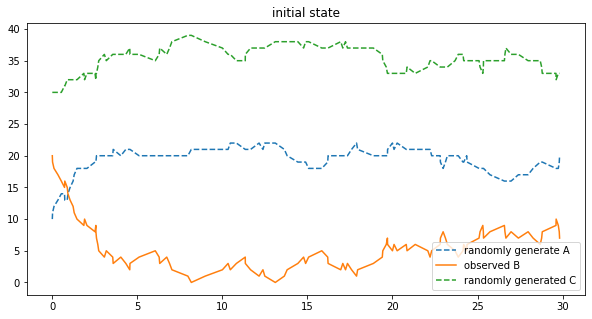

In [8]:
plt.figure(figsize=(10,5))
plt.plot(t,init_a,'--',label='randomly generate A')
plt.plot(t,init_b,label='observed B')
plt.plot(t,init_c, '--', label='randomly generated C')
plt.legend()
plt.title('initial state')

In this particular partial implementation, the only things we can change are 
- kinetic rates
- interchanging reactions 2 and 3. i.e. $B \xLeftrightarrow[k_4]{k_3} C$
- the initial population of the $B,C$

In [9]:
def get_box(k, box_size):

    box = []
    volume = 1

    for t in k:
        lower = max(t-box_size, 0)
        upper = t+box_size
        box.append((lower, upper))
        volume *= (upper-lower)

    box = np.array(box).T

    return box, volume

def move_k(state, box_size=1e-2):
    k = state[0]
    X = state[1].copy()
    box, volume = get_box(k, box_size)
    new_k = np.random.uniform(*box)

    _, volume2 = get_box(new_k, box_size)

    return (new_k, X), np.log(volume/volume2)


def get_poss(state):
    _, X = state
    a,b,c = X.T
    r = np.insert(get_r(X),0,-1)
    a_min = np.minimum.accumulate(a[::-1])[::-1]
    c_min = np.minimum.accumulate(c[::-1])[::-1]
    
    possibilities = list(np.where((a_min > 0) & ((r==1) | (r==3)))[0]) + list(np.where((c_min > 0) & ((r==0) | (r==2)))[0])

    # these moves the initial copy number, so they are not allowed in this experiment.
    # if a_min[0] > 0 :
    #     possibilities.append(0)

    # if c_min[0] > 0 :
    #     possibilities.append(-1)
    
    return np.random.choice(possibilities), r, len(possibilities)

def move_copy_number(state):
    '''
    this is merged with moving the initial copy number.
    
    returns (k,a,b,c), log_p. but how to compute log_p? this would be very computationally expensive. 
    '''
    poss,r, p = get_poss(state)
    k = state[0].copy()
    X = state[1].copy()
    
    a,b,c = X.T
    
    if poss == 0:
        a += -1
        c += 1
    
    elif poss == -1:
        a += 1
        c += -1
    else:
        if r[poss] in [1,3]:
            a[poss:] += -1
            c[poss:] += 1
        else:
            a[poss:] += 1
            c[poss:] += -1
    
    X =  np.array([a,b,c]).T
    
    new_state = [k,X]
    _,_, q = get_poss(new_state)
    return new_state, np.log(p/q)

In [10]:
def mcmc(initial_state, n):

    samples = [initial_state]
    if_accepted = []

    prev_log_pst = log_likelihood(initial_state)

    for i in tqdm(range(n), desc='sampling state space'):
        
        if np.random.uniform() < 0.5:
            move = 1
            new_state, log_p = move_copy_number(samples[-1])
        else:
            move = 2
            new_state, log_p = move_k(samples[-1])
        
        curr_log_pst = log_likelihood(new_state)
        log_acceptance = curr_log_pst - prev_log_pst + log_p
        if log_acceptance >= 0 or np.log(np.random.uniform()) < log_acceptance:
            samples.append(new_state)
            prev_log_pst = curr_log_pst
            if_accepted.append(move)
        else:
            samples.append(samples[-1])
            if_accepted.append(0)
    return samples, np.array(if_accepted)

I am going to have a test on the move_state function

In [11]:
pst_samples,if_accepcted = mcmc(initial_state, n=int(2e5))

sampling state space: 100%|██████████| 200000/200000 [18:15<00:00, 182.58it/s]


In [12]:
pst_k = np.array([i[0] for i in pst_samples])

Text(0.5, 1.0, 'histogram of sampled kinetic rates, k1. \n red line is the true kinetic rate used to generate the data')

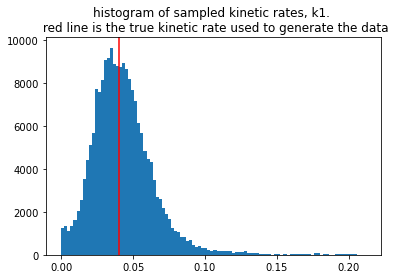

In [13]:
plt.hist(pst_k[:,0], bins=100)
plt.axvline(kinetic_rates[0], color='r')
plt.title('histogram of sampled kinetic rates, k1. \n red line is the true kinetic rate used to generate the data')

Text(0.5, 1.0, 'histogram of sampled kinetic rates, k1. \n red line is the true kinetic rate used to generate the data')

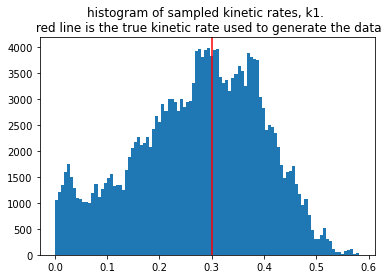

In [14]:
plt.hist(pst_k[:,1], bins=100)
plt.axvline(kinetic_rates[1], color='r')
plt.title('histogram of sampled kinetic rates, k1. \n red line is the true kinetic rate used to generate the data')

Text(0.5, 1.0, 'histogram of sampled kinetic rates, k3. \n red line is the true kinetic rate used to generate the data')

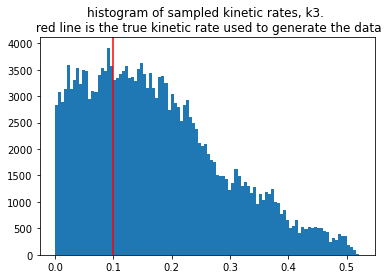

In [15]:
plt.hist(pst_k[:,2], bins=100)
plt.axvline(kinetic_rates[2], color='r')
plt.title('histogram of sampled kinetic rates, k3. \n red line is the true kinetic rate used to generate the data')

Text(0.5, 1.0, 'histogram of sampled kinetic rates, k4. \n red line is the true kinetic rate used to generate the data')

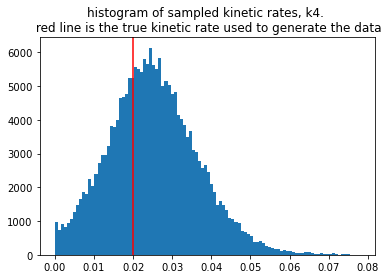

In [16]:
plt.hist(pst_k[:,3], bins=100)
plt.axvline(kinetic_rates[3], color='r')
plt.title('histogram of sampled kinetic rates, k4. \n red line is the true kinetic rate used to generate the data')

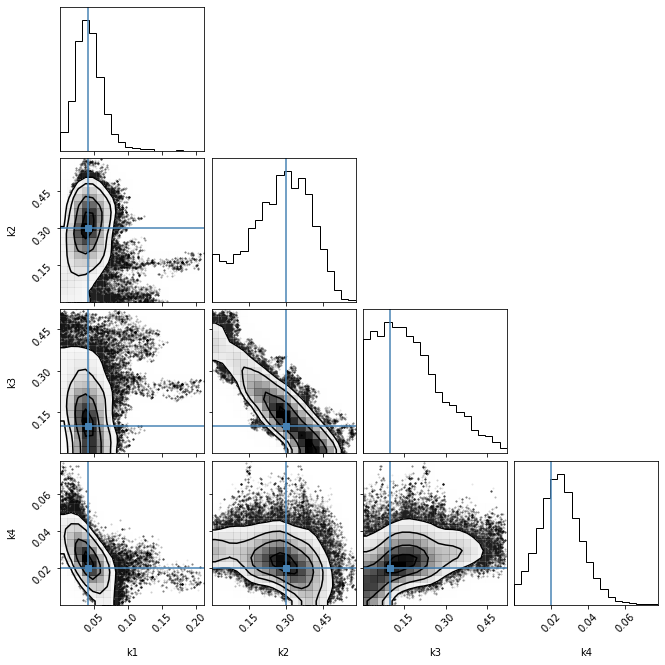

In [17]:
corner.corner(pst_k[1000:], labels=['k1','k2','k3','k4'], truths=kinetic_rates, smooth=1);

In [18]:
from statsmodels.tsa.stattools import acf

Text(0.5, 1.0, 'autocorrelation of k1')

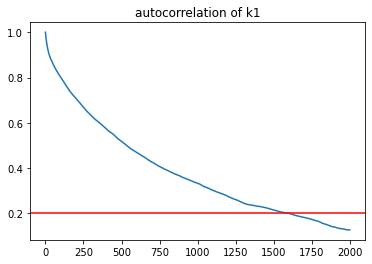

In [20]:
plt.plot(acf(pst_k[:,0],nlags = 2000))
plt.axhline(0.2, color='r')
plt.title('autocorrelation of k1')